# Pairs Trading Strategy

A pairs trading strategy is a non-directional, mean reverting trading strategy that involves utilising statistical and technical analysis to generate alpha. 

It matches a long position and a short position across a pair of equity securities that share an underlying economic link and are highly correlated. The positions are opened when the pair is trading at a price relationship out of their historical trading range and closed when they revert back to equilibrium. This price relationship is usually modelled via the price spread/ratio.

In Pairs Trading, one asset's long will always be hedged against another's short and vice versa. Thus it falls under the mean reversion or statistical arbitrage umbrella of quantitative trading strategies as it has a distinct advantage of always being hedge against market movements.

#### Assumptions
Two correlated assets will drift in and out of equilibrium (based on spread/ratio) which provides opportunities to capitalise on statistical arbitrage where we:

- Long the undervalued security
- Short the overvalued security

#### Goals
1. Modelling the economic link between asset pairs to identifying a tradable asset pair that has a clearly identified equilibrium based on statistical analysis
2. Building a model that produces trading signals for our strategy that capitalises on assets trading out of equilibrium 


## Goal 1: Identifying Tradable Asset Pairs

### Acquiring Data

First we have to get historical pricing data. We create a function that returns adjusted close as our primary data in a pandas DataFrame. We'll be using historical data from 2 years prior.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

/Users/Riley/Library/Python/3.9/lib/python/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Get historical pricing data
def getHistoricalData(tickers, start, end):
    """ This function returns a pd Dataframe with all adj closing information of tickers passed"""
    s_year, s_month, s_day = start
    e_year, e_month, e_day = end
    # Getting data from Yahoo Finance
    df = yf.download(tickers, datetime(s_year, s_month, s_day), datetime(e_year, e_month, e_day), group_by='tickers')
    # Grabbing the adj close data
    df = df.iloc[:, df.columns.get_level_values(1)=='Adj Close']
    df.columns = df.columns.droplevel(1)
    
    return df

### Correlation
Correlation refers to the extent to which two random varaibles are linearly related and can be used to find a suitable pair to trade. While it's easy to implement and interpret, it does not provide a statistically strong condition (we will see why in a bit, and use a stronger condition) when used on it's own.

$$ Corr(X,Y), \rho = \frac{Cov(X,Y)}{\sigma_X\sigma_Y} $$

Qualitatively, companies from the same sector would be more than likely to produce price movements that are very similar. In this project, we will be using a basket of 10 equities belonging to finance companies in the S&P500 index to sieve out a pair that is highly correlated in hopes of determining an asset pair that provides mean reverting opportunities.

In [3]:
tickers = ['BK', 'BAC', 'WFC', 'C', 'CFG', 'GS', 'MS', 'TFC', 'JPM', 'SCHW']
start = [2020,1,1]
end = [2022,1,1]

prices = getHistoricalData(tickers, start, end)
print(prices.shape)
prices.tail() # to show most recent data

[*********************100%***********************]  10 of 10 completed
(506, 10)


,CFG,GS,TFC,BAC,SCHW,MS,WFC,BK,C,JPM
Date,,,,,,,,,,
2021-12-27,46.844635,388.040009,58.031590,44.639999,85.638405,99.705193,48.552006,58.179127,60.176029,157.217621
2021-12-28,46.943878,387.609985,58.269833,44.700001,85.319084,99.278168,48.203568,58.119473,60.146259,157.694748
2021-12-29,46.943878,386.200012,58.349243,44.630001,84.780228,98.046753,48.233437,58.029999,60.066887,157.615234
2021-12-30,46.914108,385.519989,58.071297,44.529999,84.301247,98.116264,47.884998,57.632332,59.957748,157.535706
2021-12-31,46.894257,382.549988,58.120930,44.490002,83.922043,97.480698,47.765533,57.741692,59.918060,157.406494


In [4]:
# Correlation Matrix
corr_matrix = prices.corr()
corr_matrix

,CFG,GS,TFC,BAC,SCHW,MS,WFC,BK,C,JPM
CFG,1.000000,0.948555,0.986976,0.971718,0.962274,0.932333,0.868306,0.931296,0.887356,0.989179
GS,0.948555,1.000000,0.919023,0.966947,0.980013,0.991522,0.842445,0.946170,0.795330,0.966236
TFC,0.986976,0.919023,1.000000,0.960068,0.936508,0.900163,0.872719,0.925322,0.896251,0.979157
BAC,0.971718,0.966947,0.960068,1.000000,0.976238,0.945820,0.917290,0.979189,0.855751,0.982982
SCHW,0.962274,0.980013,0.936508,0.976238,1.000000,0.971031,0.851796,0.952721,0.781994,0.971439
MS,0.932333,0.991522,0.900163,0.945820,0.971031,1.000000,0.795533,0.929386,0.752516,0.946966
WFC,0.868306,0.842445,0.872719,0.917290,0.851796,0.795533,1.000000,0.920808,0.887361,0.900209
BK,0.931296,0.946170,0.925322,0.979189,0.952721,0.929386,0.920808,1.000000,0.820189,0.948094
C,0.887356,0.795330,0.896251,0.855751,0.781994,0.752516,0.887361,0.820189,1.000000,0.893760
JPM,0.989179,0.966236,0.979157,0.982982,0.971439,0.946966,0.900209,0.948094,0.893760,1.000000


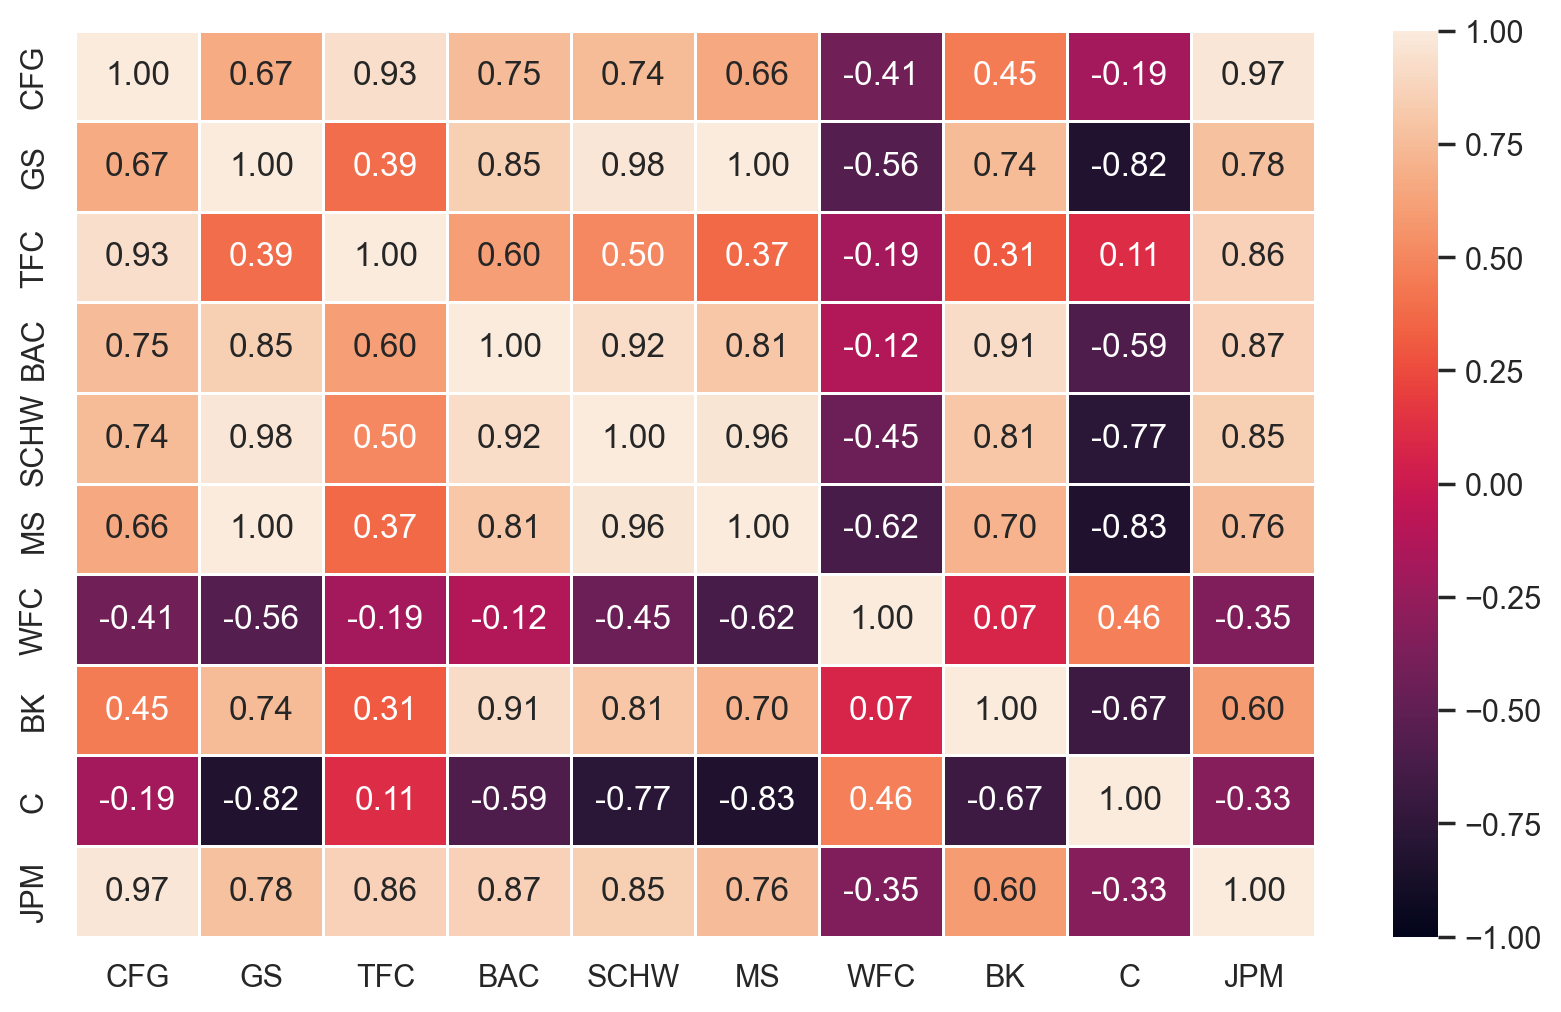

In [5]:
# Printing correlation matrix out as a heatmap
plt.figure(figsize=(10, 6), dpi=200)
sb.heatmap(corr_matrix.corr(), vmin = -1, vmax = 1, linewidths = 1, annot = True, fmt='.2f');

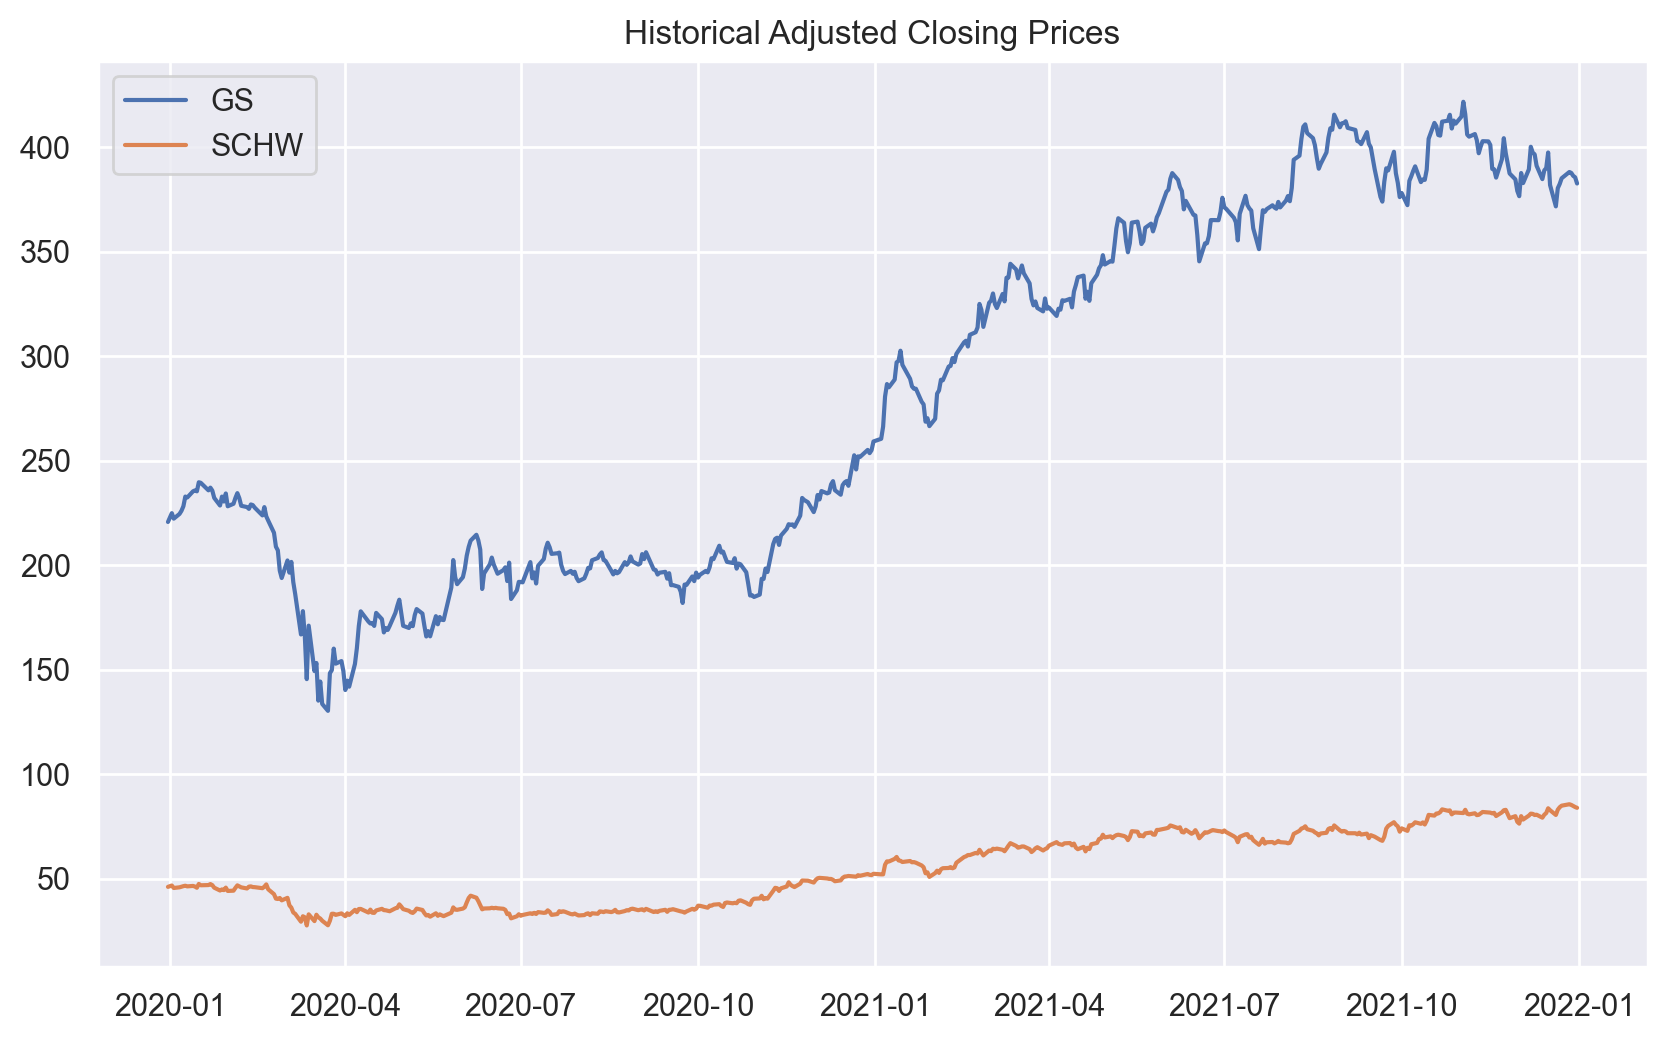

In [6]:
# High Correlation between GS and SCHW of ~ 0.98
plt.figure(figsize=(10, 6), dpi=200)
GS = prices['GS']
SCHW = prices['SCHW']
plt.plot(GS, label = 'GS')
plt.plot(SCHW, label = 'SCHW')
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show();

### Spread

Now that we have our two assets, we need to discern if they're a tradable assset pair. We model their price relationship via the spread. Price ratio can be used as well but for this notebook, the spread would be used.

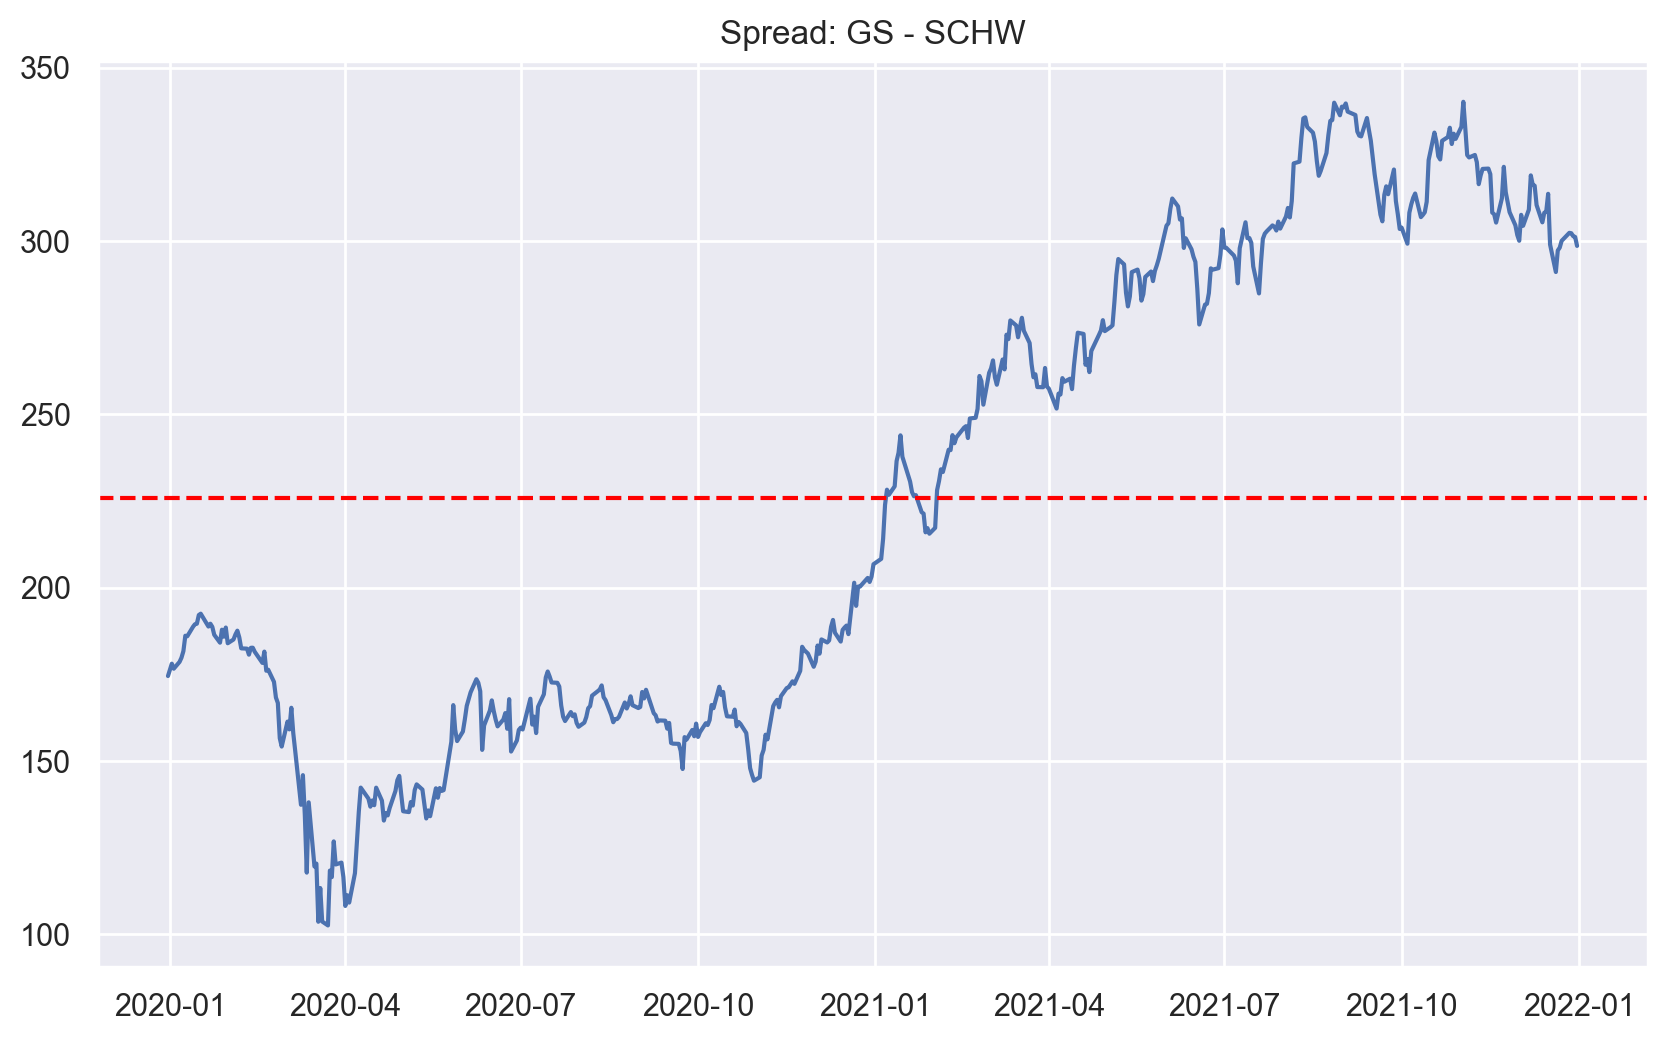

In [7]:
# plot the spread
plt.figure(figsize=(10, 6), dpi=200)
spread = GS-SCHW
spread.name = 'GS-SCHW'
plt.plot(spread)

# Add the mean
plt.axhline(spread.mean(), color='red', linestyle='--') 
plt.title("Spread: GS - SCHW")
plt.show();

### Stationarity and Cointegration

Referring back to our main assumption, the idea is to try and establish a stationary relationship that can be traded within the pair. With a stationary spread, we can go long (in the above spread - long GS, short SCHW) when the spread is small and go short (short GS, long SCHW) when the the spread is large as we will have high confidence that they are mean reverting.

#### Stationarity
A time series is defined as sationary in mathematics and statistics when the parameters of the data generating process do not change over time. This means that it's mean and standard deviation remain constant. If the mean of a spread is dynamic, the mean reversion pairs trading strategy will fail as descriptive statistics would be meaningless.

#### Cointegration
Intuitively, cointegration tests are used to establish correlation between the time series in the long term and proves to be a more robust condition to understand if two time series behave similarly to one another.

Cointegration is defined as follows: For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated. In other wards, if a linear combination of non-stationary variables produces a stationary series, then they are cointegrated.

#### Testing for stationarity
To test for a stationary spread, we can conduct cointegration tests like the `Engle-Granger` for a multi-variate time series or the `Augmented Dickey Fuller` test for a uni-variate time series.

#### GS-SCHW Spread
The spread between GS-SCHW looks like it's following a increasing trend and does not look stationary. If we trade on this time series, we will get garbage signals. Furthermore the computed mean shows the mean of all data points at a certain snapshot in time, it is meaningless to use this mean to forecast future price movements if its dynamic. Thus, we require the spread to be stationary to do apply meaningful mean reversion strategy.

#### Engle Grager Test

In [8]:
def engleGrangerTest(S1, S2, cutoff=0.05):
    """This function discerns if 2 variables are cointegrated by the Engle Granger Test"""
    result = coint(S1, S2)
    score, pvalue, _ = result
    
    if pvalue < cutoff:
        print(f'p-value = {pvalue}. Hence there likely exists a linear combination of the 2 series, {S1.name} and {S2.name}, that are stationary.')
    else:
        print(f'p-value = {pvalue}. Hence there likely does not exist a linear combination of the 2 series, {S1.name} and {S2.name}, that are stationary.')

engleGrangerTest(GS, SCHW)

p-value = 0.2657584369698383. Hence there likely does not exist a linear combination of the 2 series, GS and SCHW, that are stationary.


#### Augemented Dickey Fuller Test

In [9]:
def adf(S, cutoff=0.05):
    """This function discerns if a series is stationary of non-stationary by ADF"""
    pvalue = adfuller(S)[1]

    if pvalue < cutoff:
        print(f'p-value = {pvalue}. Hence the series, {S.name} is likely stationary.')
    else:
        print(f'p-value = {pvalue}. Hence the series, {S.name} is likely non-stationary.')

adf(spread)

p-value = 0.8900056064937159. Hence the series, GS-SCHW is likely non-stationary.


Since the spread between GS and SCHW are not cointegrated and non-stationary by both our tests, we cannot implement a pairs trading strategy on said pair and need to look for another applicable pair to trade on.

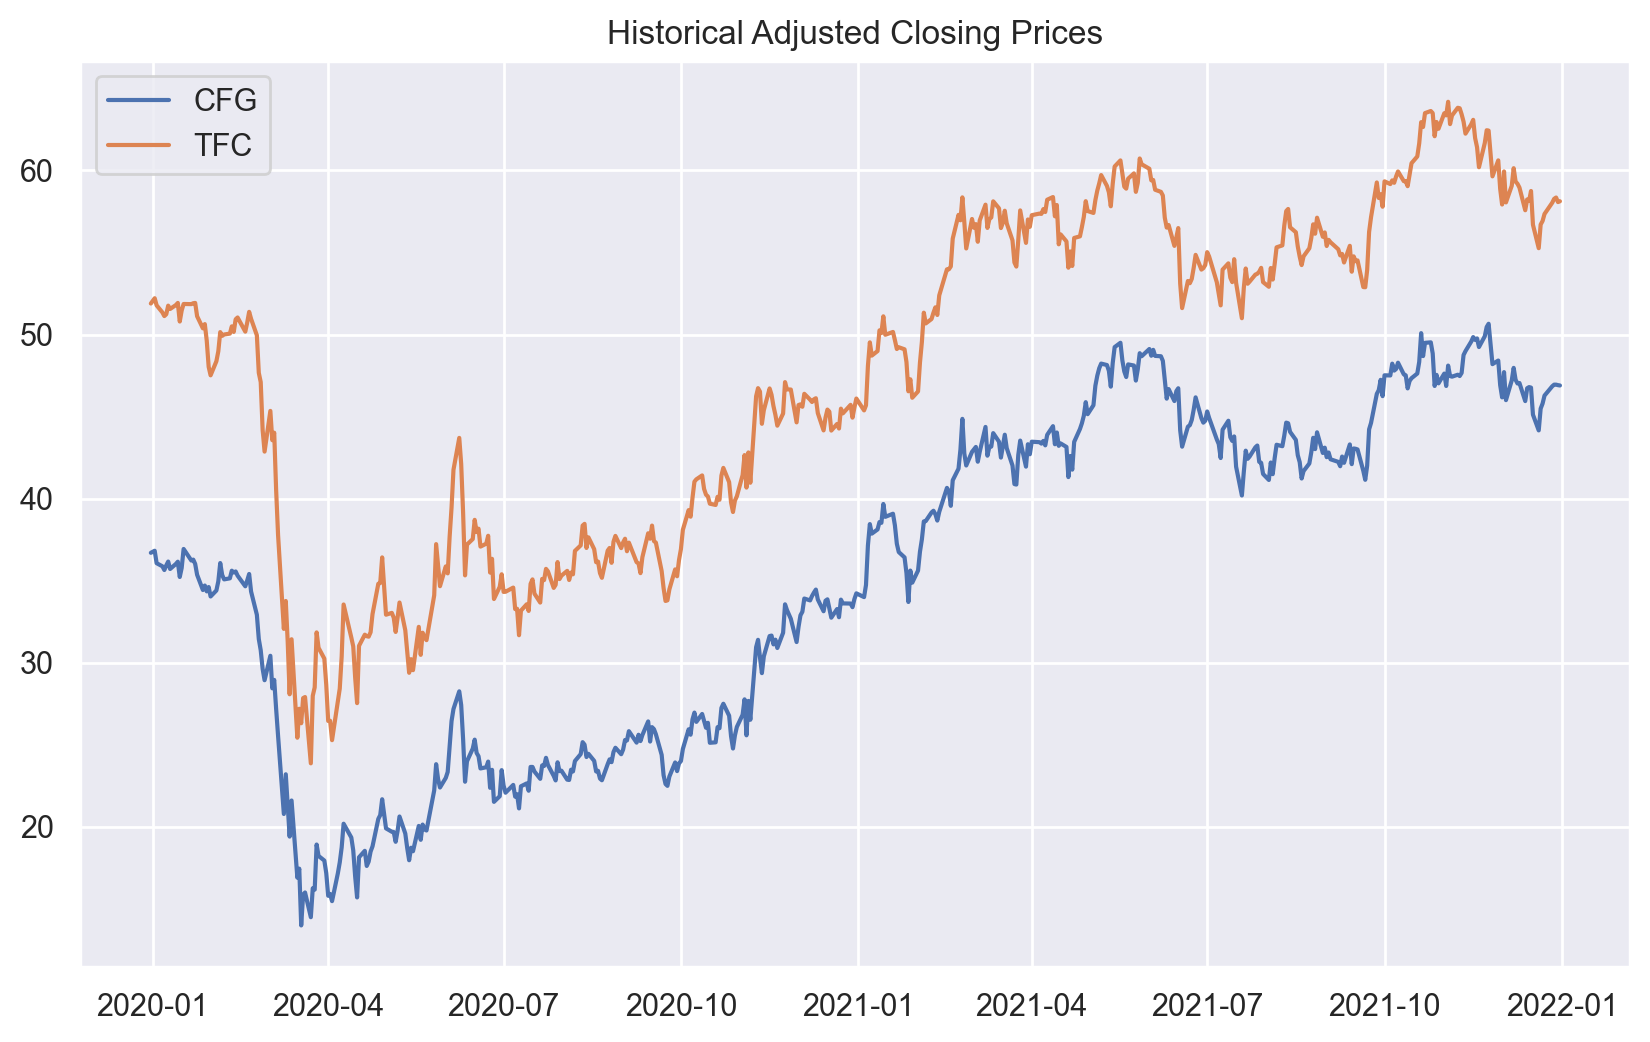

In [10]:
# High correlation between CFG and TFC of ~ 0.93
plt.figure(figsize=(10, 6), dpi=200)
CFG = prices['CFG']
TFC = prices['TFC']
plt.plot(CFG, label = 'CFG')
plt.plot(TFC, label = 'TFC')
plt.title('Historical Adjusted Closing Prices')
plt.legend()
plt.show();

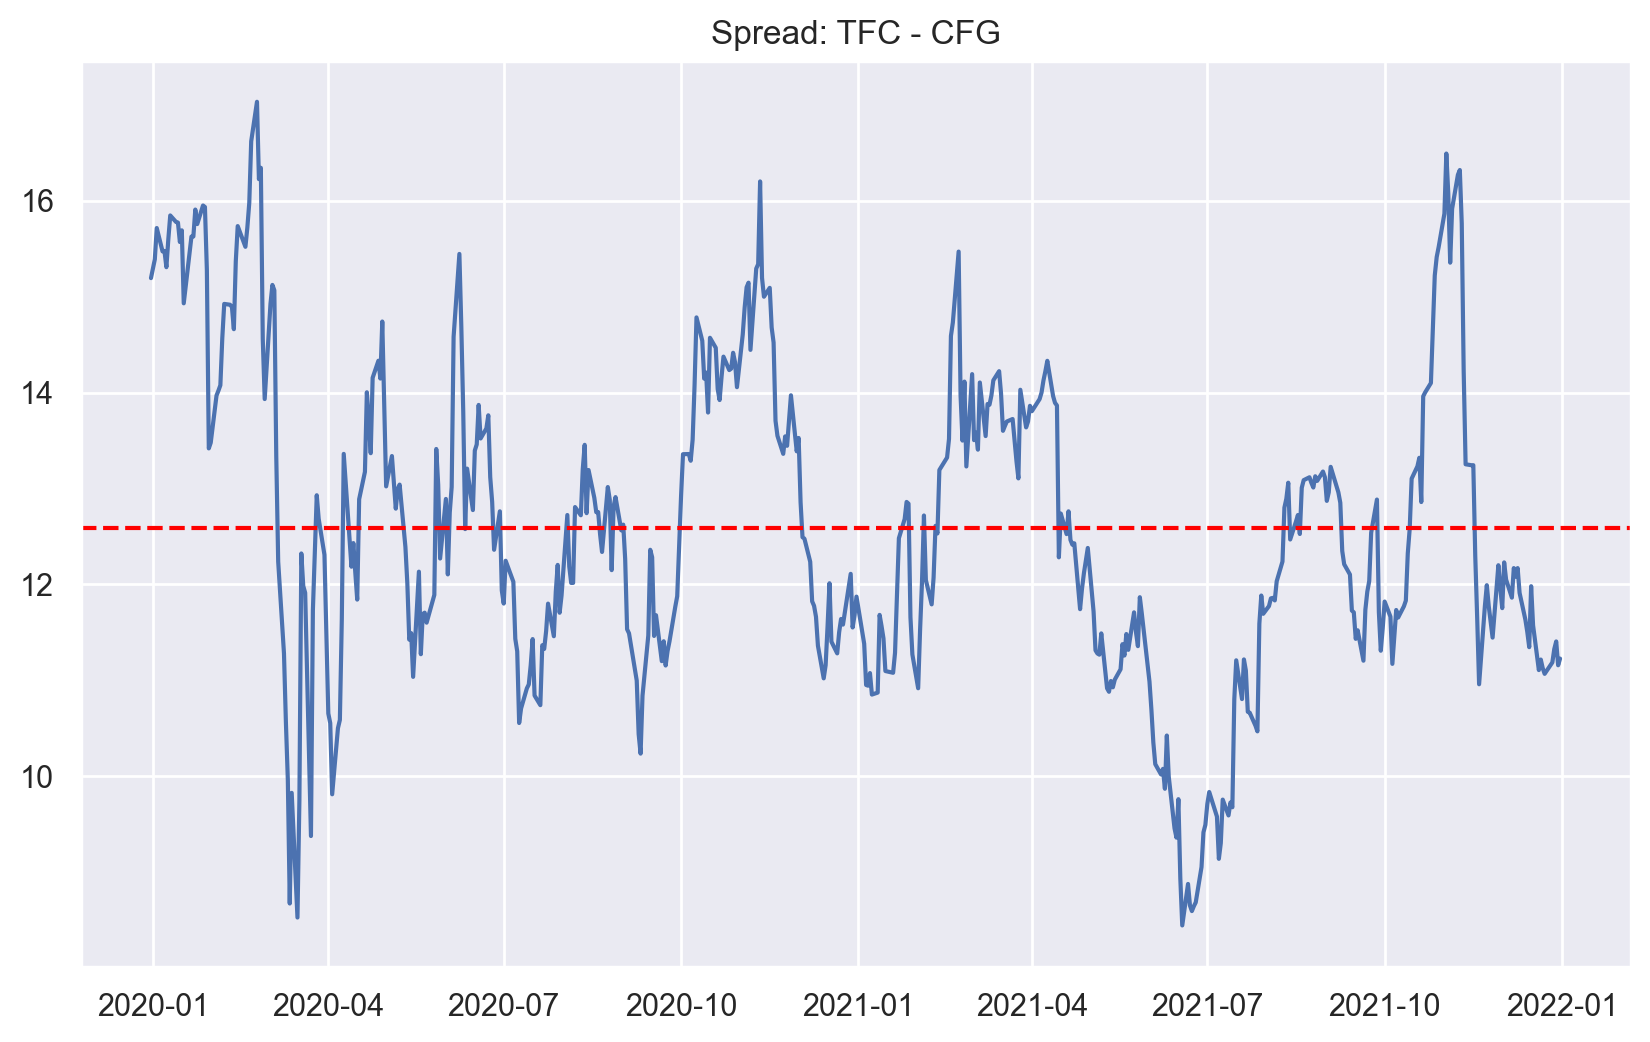

In [11]:
# plot the spread
plt.figure(figsize=(10, 6), dpi=200)
spread = TFC - CFG
spread.name = 'TFC-CFG'
plt.plot(spread)

# Add the mean
plt.axhline(spread.mean(), color='red', linestyle='--') 
plt.title("Spread: TFC - CFG")
plt.show();

This time the spread looks a lot more stationary. But we have to prove it statistically.

Similarly, we conduct our cointegration tests to check for stationarity on the TFC-CFG spread.

In [12]:
engleGrangerTest(TFC, CFG)

p-value = 0.013796734790469951. Hence there likely exists a linear combination of the 2 series, TFC and CFG, that are stationary.


In [13]:
adf(spread)

p-value = 0.003424579757223571. Hence the series, TFC-CFG is likely stationary.


An interesting point to note is that the time series of `TFC` and `CFG` are clearly non-stationary but when combined, form a stationary time series. This therefore implies they are cointegrated which is used to describe two or more non-stationary time series that can be linearly combined to form a stationary one. 

The statistical tests above signifies stationarity in the spread between `TFC` and `CFG`. We can confidently say that if the spread goes above or below a certain value, we can expect it to revert back to its mean. This presents a statistical arbitrage opportunity for us to capitalize on.

## Goal 2: Building Model Based on Statistical Analysis

Now that we have defined a pair of assets (TFC, CFG) whose spread is stationary by our cointegration tests defined above, we need to standardize the spread as the absolute spread might not be normally distributed, which can lead to skewed statistical analysis.

We thus use z-scores (no. of standard deviations a datapoint is from the mean) to generate trading signals for our trading strategy - specfically trading signals of when to long/short the spread.

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

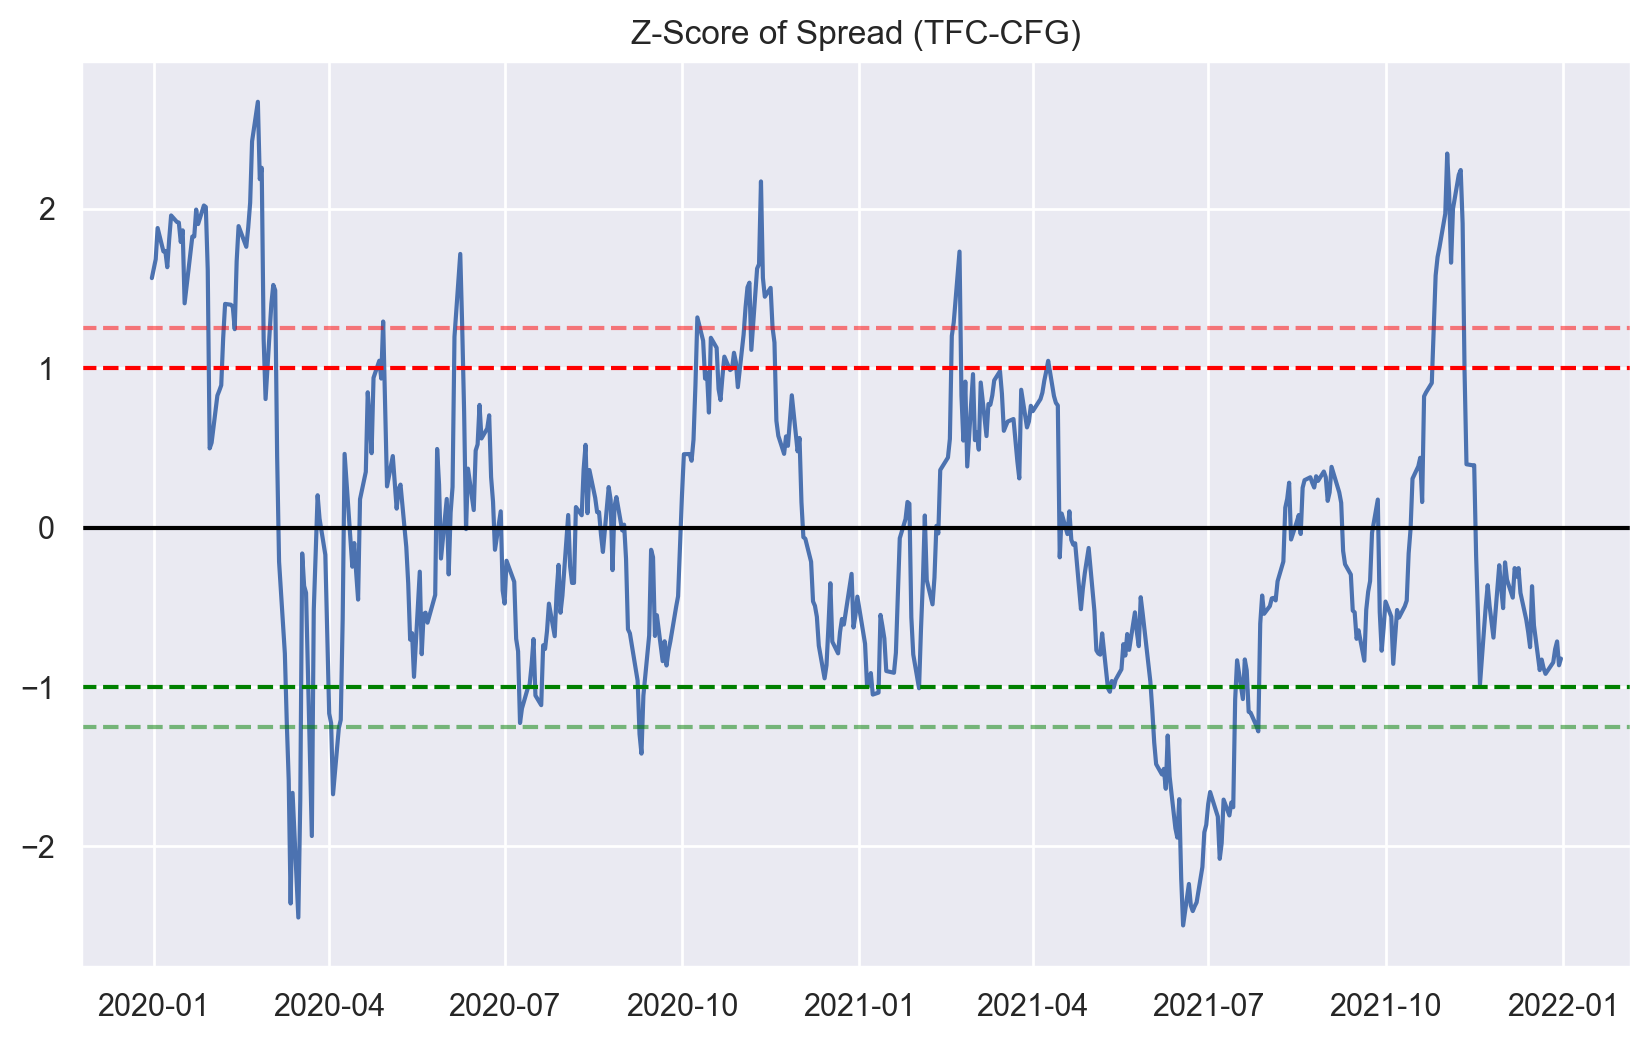

In [14]:
def zscore(S):
    return (S - S.mean()) / np.std(S)

plt.figure(figsize=(10,6), dpi=200)
plt.plot(zscore(spread))
plt.axhline((zscore(spread)).mean(), color = 'black')

# Setting the upper and lower bounds to be the z score of 1 and -1 where 68% of our data will lie between
plt.axhline(1.0, color='red', linestyle='--') 
plt.axhline(-1.0, color='green', linestyle='--') 

# 95% of our data will lie between these bounds
plt.axhline(1.25, color='red', alpha=0.5, linestyle='--') 
plt.axhline(-1.25, color='green',alpha=0.5, linestyle='--')
plt.title('Z-Score of Spread (TFC-CFG)')
plt.show();

By setting 4 other lines placed at the z-score of 1 and -1, 1.25, -1.25, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This helps us determine when and what bets to place.

1. <b>Long the spread (long TFC, short CFG) when it falls below the green lines.</b> 
2. <b>Short the spread (short TFC, long CFG) when it falls below the green lines.</b>

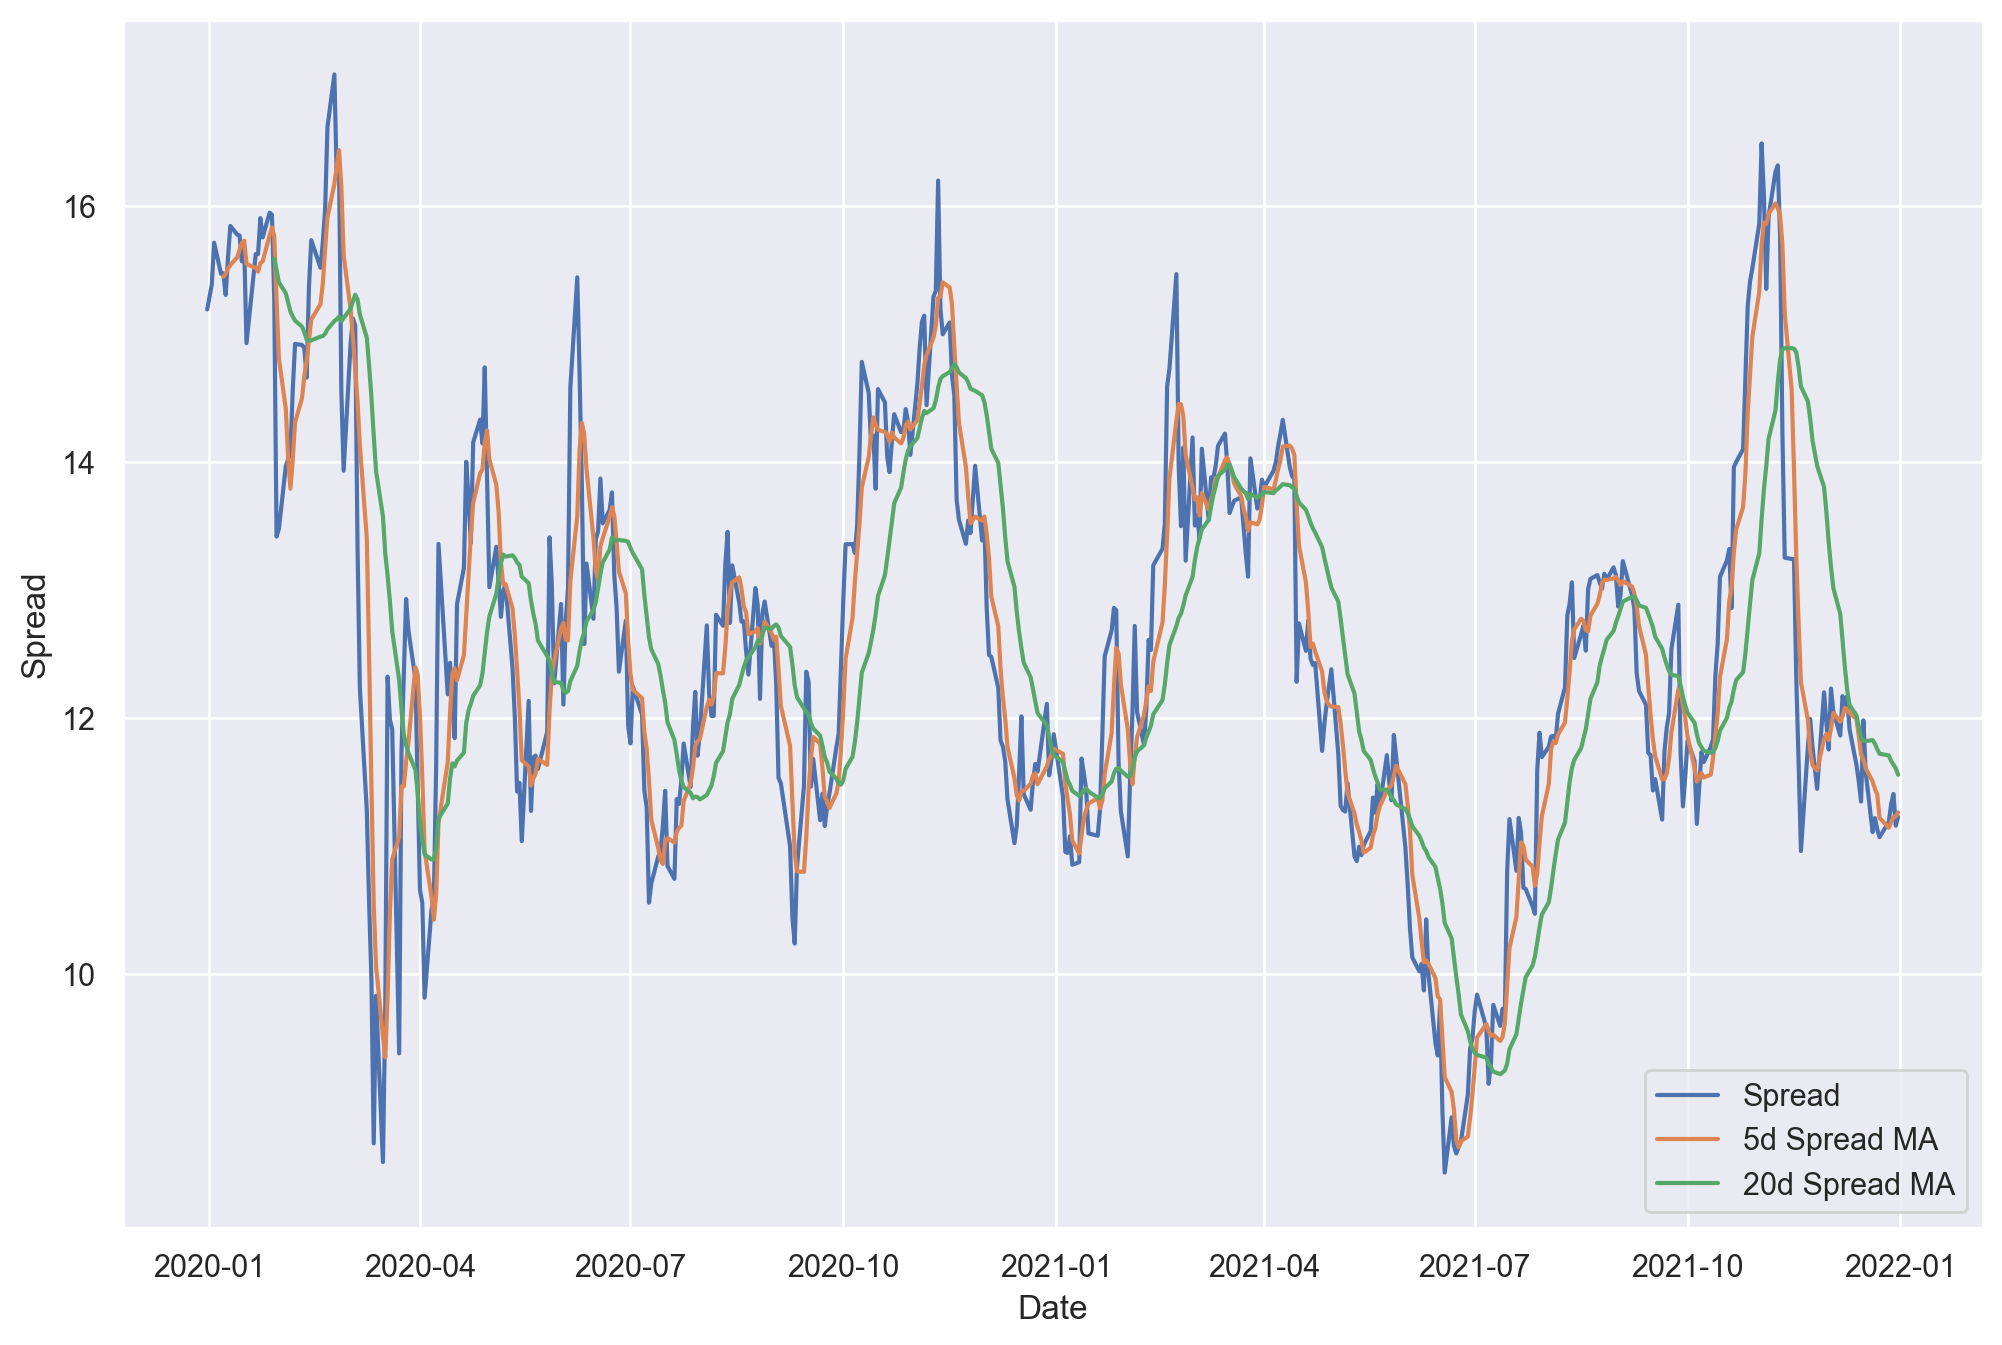

In [15]:
plt.figure(figsize=(12, 8), dpi=200)
spreads_mavg5 = spread.rolling(window=5, center=False).mean()
spreads_mavg20 = spread.rolling(window=20, center=False).mean()
plt.plot(spread.index, spread.values)
plt.plot(spreads_mavg5.index, spreads_mavg5.values)
plt.plot(spreads_mavg20.index, spreads_mavg20.values)
plt.legend(['Spread', '5d Spread MA', '20d Spread MA'])
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()

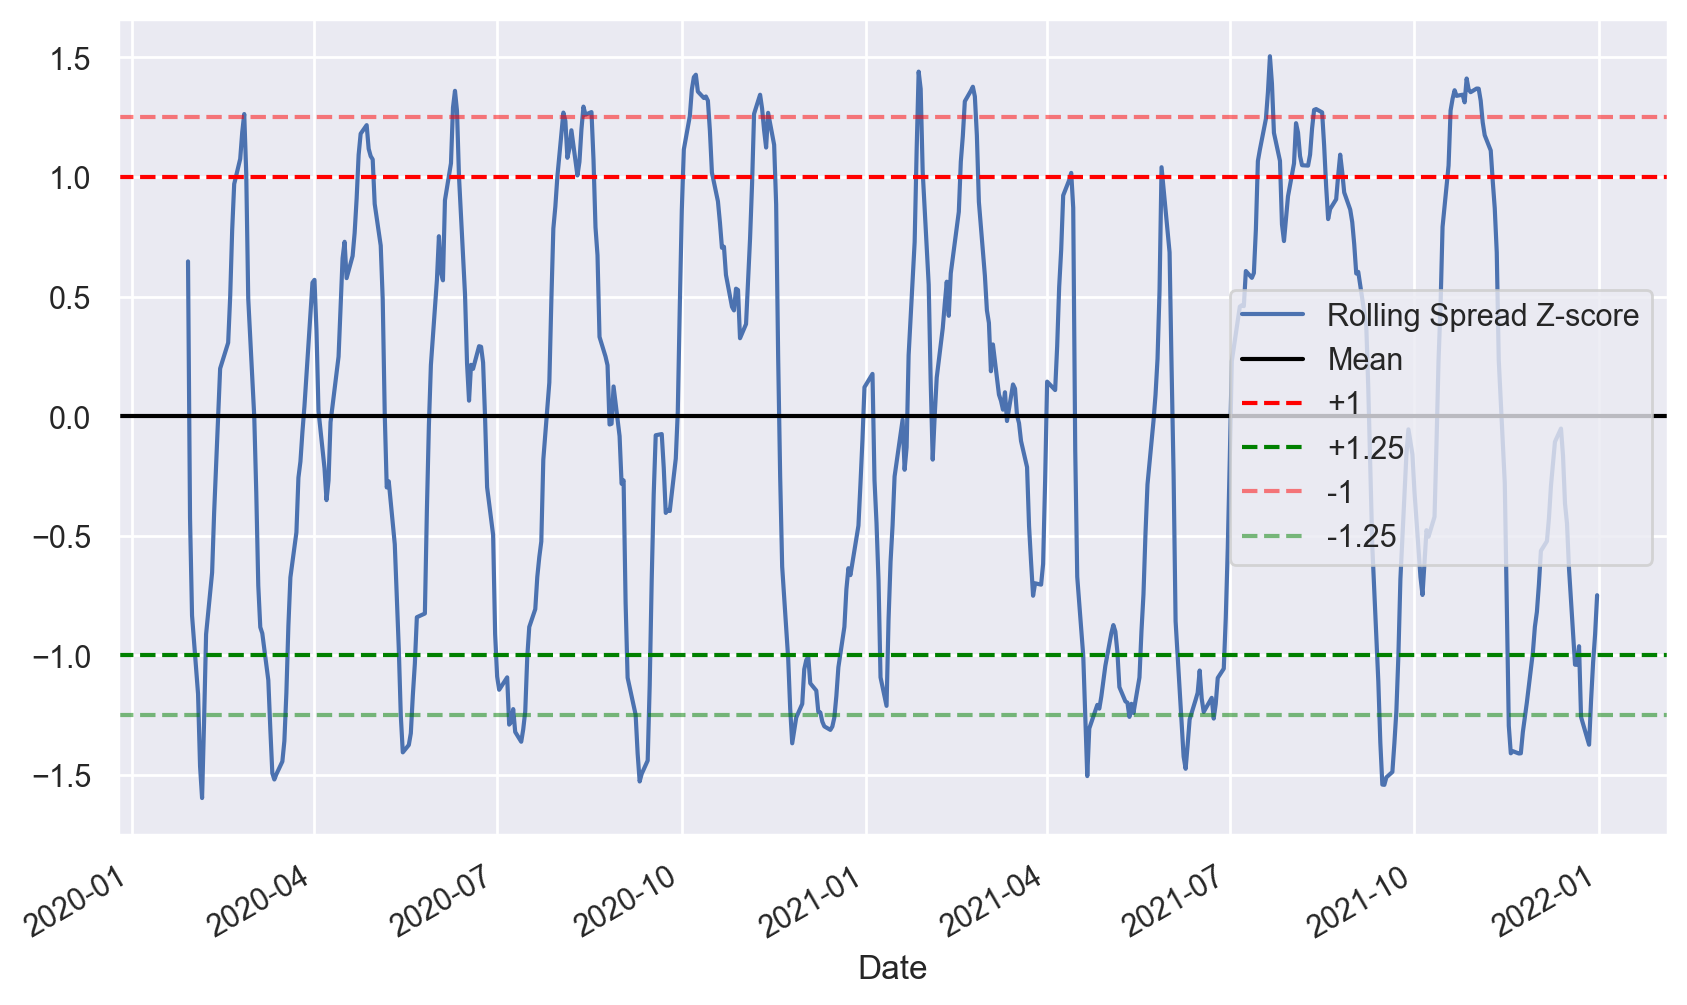

In [16]:
plt.figure(figsize=(10, 6), dpi=200)

std_20 = spread.rolling(window=20, center=False).std()
zscore_20_5 = (spreads_mavg5 - spreads_mavg20)/std_20
zscore_20_5.plot()

plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')

plt.axhline(1.25, color='red', alpha=0.5, linestyle='--')
plt.axhline(-1.25, color='green', alpha=0.5, linestyle='--')

plt.legend(['Rolling Spread Z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

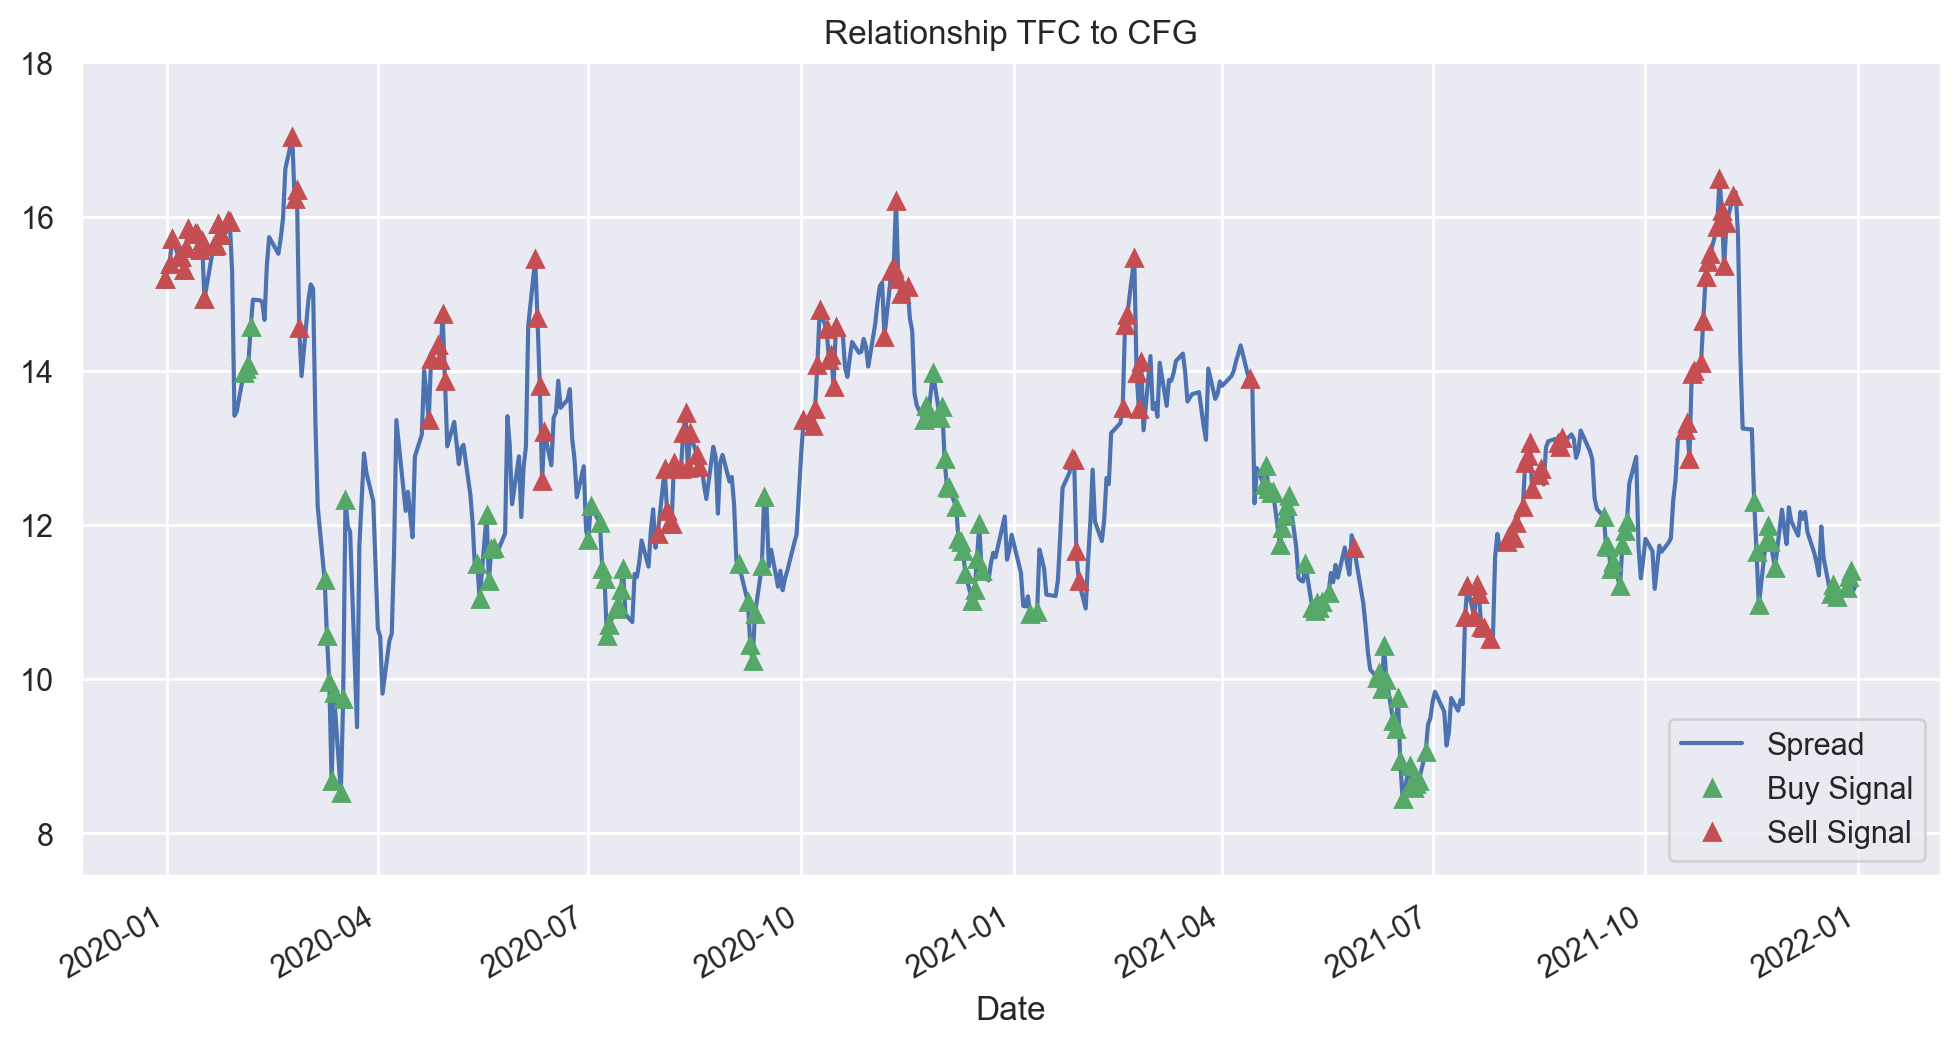

In [17]:
plt.figure(figsize=(12, 6), dpi=200)
spread.plot()

buy = spread.copy()
sell = spread.copy()

buy[zscore_20_5>-1] = 0 # Long TFC, short CFG
sell[zscore_20_5<1] = 0 # Short TFC, long CFG

buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, spread.min()-1, spread.max()+1))
plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship TFC to CFG')
plt.show()

## Areas for improvement

1. Backtesting strategy
2. Producing cointegration heat map on all pairs that are cointegrated from basket of selection
3. Using linear regression on find cointegrated linear combination and use that to model spread and buy/sell signals